# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0))

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
from PIL import Image
import site
import numpy as np
import pandas as pd
import os
import sys
import tarfile
from IPython.display import display
from IPython.display import Image as image2
from scipy import ndimage
from os.path import isfile, join
import h5py
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
%matplotlib inline

In [2]:
from dataprep import *

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz
notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']
notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pi

In [3]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 188400437


In [4]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save 

In [5]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size, image_size)).astype(np.float32)

  #labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  labels = labels.astype(np.int32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (40000, 28, 28) (40000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [6]:
####approach to create synthetic with own modifications but based on udacity forum discussion####
def createSequences(ndarr, labels_raw):
    length_number = 5
    stacked_pixelrow = image_size*length_number
    dataset_size = ndarr.shape[0]
    dataset_new = np.ndarray(shape=(dataset_size, image_size, stacked_pixelrow),
                         dtype=np.float32)

    data_labels = []

    i = 0
    w = 0
    #1/5 of total size since we always handle 5 images at once
    while i < (dataset_size/length_number):
        temp = np.hstack(
            [ndarr[w], ndarr[w + 1], ndarr[w + 2], ndarr[w + 3], ndarr[w + 4]])
        ##if we keep this with i, we will have 32000 blue boxes
        dataset_new[i, :] = temp
        #adding a label id 5 for pos [0] to suggest length of number#
        temp_str = [labels_raw[w], labels_raw[
                    w + 1], labels_raw[w + 2], labels_raw[w + 3], labels_raw[w + 4]]
        data_labels.append(temp_str)
        w += length_number
        i += 1
    #asarray instead of array, otherwise returns list 
    #still returns list
    np.asarray(data_labels)

    return dataset_new, data_labels

In [7]:
train_dataset, train_labels = createSequences(train_dataset, train_labels)
valid_dataset, valid_labels = createSequences(valid_dataset, valid_labels)
test_dataset, test_labels = createSequences(test_dataset, test_labels)

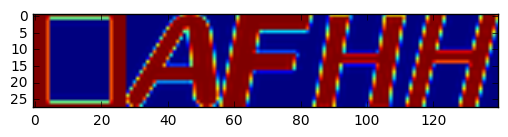

Label : [8, 0, 5, 7, 7]


In [8]:
import random

def displaySequence(n):
    fig=plt.figure()
    plt.imshow(train_dataset[n])
    plt.show()
    print ('Label : {}'.format(train_labels[n]))
    
displaySequence(7999)

In [9]:
#necessary to resize since we plugged 4/5th of our data into 1/5th
train_dataset = train_dataset[:8000]
valid_dataset = train_dataset[:2000]
test_dataset = train_dataset[:2000]

In [10]:
print('Training set', train_dataset.shape, len(train_labels))
print('Validation set', valid_dataset.shape, len(valid_labels))
print('Test set', test_dataset.shape, len(test_labels))

Training set (8000, 28, 140) 8000
Validation set (2000, 28, 140) 2000
Test set (2000, 28, 140) 2000


In [11]:
#changing image aspect ratio to lower learning burden on network

def resize_dataset(dataset):
    dataset_new = dataset[:,:,:28]
    for i in range(dataset.shape[0]):
        for pix_h in range(0,27):
            pix_w_new = 0
            for pix_w in range(0,134):               
                if pix_w % 5 == 0:
                    dataset_new[i][pix_h][pix_w_new] = (dataset[i][pix_h][pix_w] +dataset[i][pix_h][pix_w+1] +dataset[i][pix_h][pix_w+2]+\
            dataset[i][pix_h][pix_w+3]+dataset[i][pix_h][pix_w+4])/5
                    pix_w_new += 1
                    #print(pix_w_new)
    print(dataset_new.shape)
    return dataset_new

In [12]:
valid_dataset = resize_dataset(valid_dataset)
test_dataset = resize_dataset(test_dataset)
train_dataset = resize_dataset(train_dataset)

(2000, 28, 28)
(2000, 28, 28)
(8000, 28, 28)


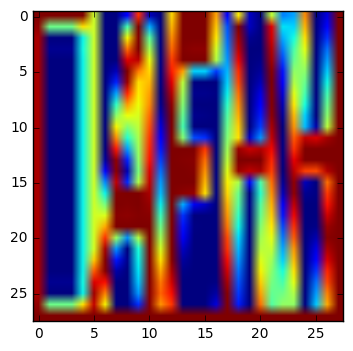

Label : [8, 0, 5, 7, 7]


In [13]:
def displaySequence(n):
    fig=plt.figure()
    plt.imshow(train_dataset[n])
    plt.show()
    print ('Label : {}'.format(train_labels[n]))
    
displaySequence(7999)

In [14]:
#some additional reformatting will prepare this for the first simple NN
channels = 1


def reshape(dataset, labels):
    dataset = dataset.reshape((-1, image_size, image_size, channels)).astype(np.float32)
    #previous reformatting didnt capture this
    labels = np.asarray(labels)
    return dataset, labels

train_dataset, train_labels = reshape(train_dataset, train_labels)
test_dataset, test_labels = reshape(test_dataset, test_labels)
valid_dataset, valid_labels = reshape(valid_dataset, valid_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
print('Valid set', valid_dataset.shape, valid_labels.shape)

Training set (8000, 28, 28, 1) (8000, 5)
Test set (2000, 28, 28, 1) (2000, 5)
Valid set (2000, 28, 28, 1) (2000, 5)


In [15]:
def accuracy_single(predictions, labels):
    #argmax selecting the value with the highest probability
    a = np.argmax(predictions, 2).T == labels[:,0:5]
    length = labels[:,0]
    summ = 0.0
    for i in range(len(length)):
        summ += np.sum(a[i,:length[i]])
    return(100 * summ / np.sum(length))

def accuracy_multi(predictions, labels):
    count = predictions.shape[1]
    return 100.0 * (count - np.sum([1 for i in np.argmax(predictions, 2).T == labels[:,0:5] if False in i])) / count

In [224]:

#pictures per training cycle
batch_size = 128
#nodes aka ?
num_hidden1 = 784
#different meaning compared to reshaping function since we now look at the type of digit and not the position 
num_labels = 10
patch = 5

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size, image_size, channels))
  #tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, num_labels))
  tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 5))
  tf_test_dataset = tf.constant(test_dataset)
  tf_valid_dataset = tf.constant(valid_dataset)
  #weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
  #biases = tf.Variable(tf.zeros([num_labels]))
    
    
  ###defining hidden layer 1 weights and biases outside the model (?)
  h1_w = tf.Variable(tf.truncated_normal([num_hidden1, batch_size]))
  h1_b = tf.Variable(tf.ones([batch_size]))

  ###defining hidden layer 2 as the one above makes performance worse!
  h2_weights = tf.Variable(tf.truncated_normal([nodes, nodes, depth1, depth2],stddev=0.1))
  h2_biases = tf.Variable(tf.ones([depth2]))

  ###each logit gets its own weight and bias here
  s1_w = tf.Variable(tf.truncated_normal([batch_size, num_labels],stddev=0.1))
  s1_b = tf.Variable(tf.ones([num_labels]))
    
  s2_w = tf.Variable(tf.truncated_normal([batch_size, num_labels],stddev=0.1))
  s2_b = tf.Variable(tf.ones([num_labels]))
  
  s3_w = tf.Variable(tf.truncated_normal([batch_size, num_labels],stddev=0.1))
  s3_b = tf.Variable(tf.ones([num_labels]))
    
  s4_w = tf.Variable(tf.truncated_normal([batch_size, num_labels],stddev=0.1))
  s4_b = tf.Variable(tf.ones([num_labels]))
    
  s5_w = tf.Variable(tf.truncated_normal([batch_size, num_labels],stddev=0.1))
  s5_b = tf.Variable(tf.ones([num_labels]))
  


 #  def forward_prop(inp):
 #       h1 = tf.nn.relu(tf.matmul(inp, weights_1) + biases_1)
  #      return tf.matmul(h1,weights_2) + biases_2
    #logits = forward_prop(tf_train_dataset)

  ###expanded version for each logit
  def model(data):
    ###this piece of code is really awkward right now and needs to be refactored when functionality is proven
    ###see tensorflow for expert tutorials?
    #layer 1 with stride 1 and no aditional padding ("input same as output")###
    conv = tf.nn.conv2d(data,layer1_weights, [1,1,1,1],padding='VALID')
    hidden = tf.nn.relu(conv + layer1_biases)
    pool = tf.nn.max_pool(learn, [1,2,2,1], [1,2,2,1], 'SAME')
    #layer 2
    conv = tf.nn.conv2d(pool, layer2_weights, [1,1,1,1], padding='VALID')
    hidden = tf.nn.relu(conv + layer2_biases)

    #reformatting
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    
    #hidden1 = tf.nn.relu(tf.matmul(data, h1_w) + h1_b)

    logits1 = tf.matmul(reshape, s1_w) + s1_b
    logits2 = tf.matmul(reshape, s2_w) + s2_b
    logits3 = tf.matmul(reshape, s3_w) + s3_b
    logits4 = tf.matmul(reshape, s4_w) + s4_b
    logits5 = tf.matmul(reshape, s5_w) + s5_b
    return [logits1, logits2, logits3, logits4, logits5]

  # Training computation.
  #for a single digit: logits = tf.matmul(tf_train_dataset, weights) + biases
  [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset)
     
  ####comparing the predicted value of each logit with the actual label to calculate losses
  #single digit: loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,0])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,1])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,2])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,3])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,4]))
    
  
  #loss reduction with adagrad
  optimizer = tf.train.AdagradOptimizer(0.015).minimize(loss)
  #optimizer = tf.train.AdamOptimizer(0.5).minimize(loss)
  
  ####getting predictions from the logits###  
  #one prediction for each position###
  def prediction(dataset):
    prediction = tf.pack([
        tf.nn.softmax(model(dataset)[0]),
        tf.nn.softmax(model(dataset)[1]),
        tf.nn.softmax(model(dataset)[2]),
        tf.nn.softmax(model(dataset)[3]),
        tf.nn.softmax(model(dataset)[4])])
    return prediction
    
    
  train_prediction = prediction(tf_train_dataset)
  test_prediction = prediction(tf_test_dataset)
  valid_prediction = prediction(tf_valid_dataset)

  saver = tf.train.Saver()

In [232]:
num_steps = 40001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()

    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    
        if (step % 10000 == 0): 
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy for single digit: %.1f%%' % accuracy_single(predictions, batch_labels))
            print('Minibatch accuracy for full picture: %.1f%%' % accuracy_multi(predictions, batch_labels))
            #print('prediction', predictions)
            #print('label', batch_labels[:,1:6])
            
    #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6])) 
    print('Test accuracy for single digit: %.1f%%' % accuracy_single(test_prediction.eval(), test_labels))
    print('Test accuracy for full picture: %.1f%%' % accuracy_multi(test_prediction.eval(), test_labels))
    print('Validation accuracy for single digit: %.1f%%' % accuracy_single(valid_prediction.eval(), valid_labels))
    print('Validation accuracy for full picture: %.1f%%' % accuracy_multi(valid_prediction.eval(), valid_labels))
    save_path = saver.save(session, "cnn.convnet")
    print("Model saved in file: %s" % save_path)

Initialized
Minibatch loss at step 0: 52.187321
Minibatch accuracy for single digit: 10.2%
Minibatch accuracy for full picture: 0.0%
Minibatch loss at step 10000: 3.618090
Minibatch accuracy for single digit: 62.7%
Minibatch accuracy for full picture: 35.2%
Minibatch loss at step 20000: 3.921928
Minibatch accuracy for single digit: 62.1%
Minibatch accuracy for full picture: 26.6%
Minibatch loss at step 30000: 3.057063
Minibatch accuracy for single digit: 65.4%
Minibatch accuracy for full picture: 38.3%
Minibatch loss at step 40000: 2.876709
Minibatch accuracy for single digit: 63.2%
Minibatch accuracy for full picture: 41.4%
Test accuracy for single digit: 6.9%
Test accuracy for full picture: 0.0%
Validation accuracy for single digit: 7.9%
Validation accuracy for full picture: 0.0%
Model saved in file: cnn.convnet


In [253]:
#with tf.Session() as sess:
 # new_saver = tf.train.import_meta_graph('cnn.convnet.meta')
 # new_saver.restore(sess, tf.train.latest_checkpoint('./'))
 # test_prediction = session.run(test_prediction, feed_dict={tf_test_dataset : test_labels[:],})
 # print(test_prediction)

### Question 1
_What approach did you take in coming up with a solution to this problem?_

The underlying data set is notmnist numbers. The udacity exercise 1_notmnist approach was borrowed to load and format the data into a pickle.
Images have been concatenated in pairs of 5 and then resized to lower the computation burden for the Neural network.
While this distorted the aspect ratio, the synthetic dataset also reduced the training sample size was to 8.000. 

I then applied a neural network with a hidden layer and relu activation functions. While the test accuracy of 7% on single digits and 0% on full images, is still very poor, localization of digits should be introduced next.
The result was obtained by reducing the learning rate from 0.5 to 0.015 and by setting the training steps to 20.000, since performance tapered off here.

Initially, a sigmoid activation function has been set, but relus performed better by a 2-4% margin and thus remained in the model


### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

The model was trained by feeding the training set in batches of 128, out of the 8.000 picture repository. While we apply offset to create the batch, overlap between individual batches per training step is avoided.

Training the model involved identifying five digits per image, while the position of the digit within the image is unknown to the network, yet within predictable ranges due to proper cropping.

The synthetic dataset was created by concatenating five images as a numpy array and by applying similar concatenation with the labels.
After obtaining imaxes of the size 28x140 pixels, image aspect ratio has been adapted and image size changed to 28x28 pixels to reduce computational burden and simplify required feature learning.

Sample images can be seen above


----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [255]:
###for preprocessing of svhn file please see svhn_prep.ipynb or *.html file###
svhn_file=h5py.File("SVHN.hdf5","r")
#print(svhn_file.keys())

train_dataset = svhn_file['train_dataset'][()]
#print(train_dataset.shape[0])
train_labels = svhn_file['train_labels'][()]
test_dataset = svhn_file['test_dataset'][()]
test_labels = svhn_file['test_labels'][()]
svhn_file.close()

[ 2  2  9 10 10 10]


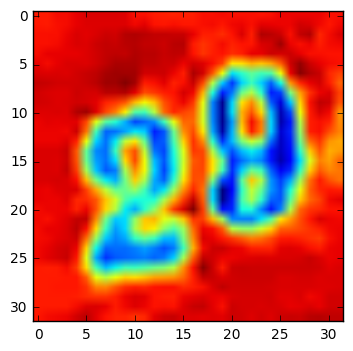

In [256]:
plt.imshow(train_dataset[100,:,:])
print(train_labels[100])

### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.